In [ ]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import nltk
import seaborn as sns
import re
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
df=pd.read_csv('Emotion_final.csv') #Text data
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


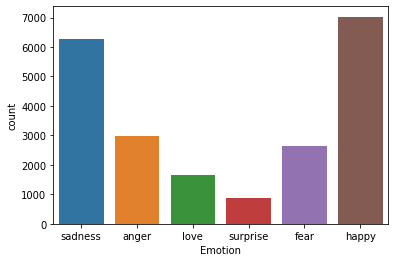

In [ ]:
#Target Classes
sns.countplot(df['Emotion']) 

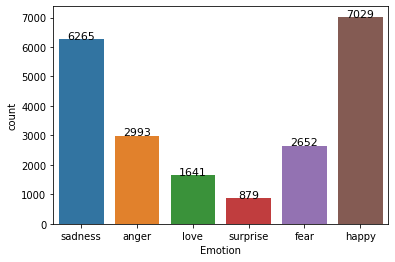

In [ ]:
ax = sns.countplot(x='Emotion', data=df)
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)


In [ ]:
df['Emotion'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'happy'],
      dtype=object)

In [ ]:
df=df.dropna()

In [ ]:
df.shape

(21459, 2)

In [ ]:
X=df.drop('Emotion',axis=1)
y=df['Emotion']

In [ ]:
### Vocabulary size
voc_size=10000

In [ ]:
messages=X.copy()
messages.reset_index(inplace=True)

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['Text'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [ ]:
corpus[:10]

['didnt feel humili',
 'go feel hopeless damn hope around someon care awak',
 'im grab minut post feel greedi wrong',
 'ever feel nostalg fireplac know still properti',
 'feel grouchi',
 'ive feel littl burden late wasnt sure',
 'ive take milligram time recommend amount ive fallen asleep lot faster also feel like funni',
 'feel confus life teenag jade year old man',
 'petrona year feel petrona perform well made huge profit',
 'feel romant']

In [ ]:
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

In [ ]:
onehot_repr[1]

[7891, 6686, 8434, 9837, 393, 3029, 8488, 5737, 5180]

In [ ]:
#Finding max words
l = 0
for x in corpus:
    l = max(l,len(x.split(' ')))

print(l)

35


In [ ]:
sent_length=35
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 2375 6686  469]
 [   0    0    0 ... 8488 5737 5180]
 [   0    0    0 ... 6686 6762 4389]
 ...
 [   0    0    0 ... 8734 7939 7483]
 [   0    0    0 ... 8215 7483 1340]
 [   0    0    0 ...    0 7483 2015]]


In [ ]:
embedded_docs[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 2375,
       6686,  469], dtype=int32)

In [ ]:
# Creating model
embedding_vector_features=100
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.01)))
model.add(Dropout(0.3))
model.add(Dense(6,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer= tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 100)           1000000   
                                                                 
 dropout (Dropout)           (None, 35, 100)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                        

In [ ]:
label_encoder = preprocessing.LabelEncoder()

X_final=np.array(embedded_docs)
y = label_encoder.fit_transform(y)
y_final=np.array(y)
print(y_final)

[4 4 0 ... 1 1 1]


In [ ]:
X_final.shape,y_final.shape

((21459, 35), (21459,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=21)

In [ ]:
X_train.shape

(15450, 35)

In [ ]:
model_save = ModelCheckpoint('weights.h5', save_best_only = True, save_weights_only = True, monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=10,batch_size=256,callbacks = [model_save])

Epoch 1/10
61/61 [==============================] - ETA: 0s - loss: 2.6055 - accuracy: 0.4296
Epoch 1: val_loss improved from inf to 1.31838, saving model to weights.h5
61/61 [==============================] - 21s 262ms/step - loss: 2.6055 - accuracy: 0.4296 - val_loss: 1.3184 - val_accuracy: 0.6459
Epoch 2/10
61/61 [==============================] - ETA: 0s - loss: 1.0550 - accuracy: 0.6952
Epoch 2: val_loss improved from 1.31838 to 0.92231, saving model to weights.h5
61/61 [==============================] - 15s 246ms/step - loss: 1.0550 - accuracy: 0.6952 - val_loss: 0.9223 - val_accuracy: 0.7292
Epoch 3/10
61/61 [==============================] - ETA: 0s - loss: 0.8257 - accuracy: 0.7685
Epoch 3: val_loss improved from 0.92231 to 0.84959, saving model to weights.h5
61/61 [==============================] - 15s 248ms/step - loss: 0.8257 - accuracy: 0.7685 - val_loss: 0.8496 - val_accuracy: 0.7612
Epoch 4/10
61/61 [==============================] - ETA: 0s - loss: 0.7090 - accuracy: 0.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


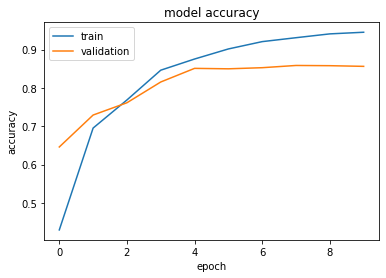

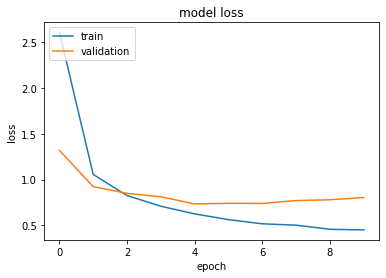

In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.load_weights('weights.h5')

In [ ]:
X_test

array([[   0,    0,    0, ..., 7097, 1569, 8838],
       [   0,    0,    0, ..., 9810, 1896, 6765],
       [   0,    0,    0, ..., 2634,  932, 4689],
       ...,
       [   0,    0,    0, ..., 9837, 7225, 5106],
       [   0,    0,    0, ..., 3650, 8587, 5659],
       [   0,    0,    0, ..., 8675, 3277, 8237]], dtype=int32)

In [ ]:
predict_x = model.predict(X_test)
y_pred = np.argmax(predict_x,axis=1)
print(y_pred )

[2 0 4 ... 0 0 2]


In [ ]:
y_test

array([2, 0, 4, ..., 0, 0, 2])

In [ ]:
print(accuracy_score(y_test,y_pred))

0.8543802423112767


In [ ]:
print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.90803   0.88006   0.89383       617
           1    0.69592   0.86629   0.77181       531
           2    0.85753   0.92397   0.88951      1381
           3    0.76190   0.65409   0.70389       318
           4    0.93169   0.91856   0.92508      1277
           5    0.53846   0.04167   0.07735       168

    accuracy                        0.85438      4292
   macro avg    0.78225   0.71411   0.71024      4292
weighted avg    0.84728   0.85438   0.84061      4292



Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)


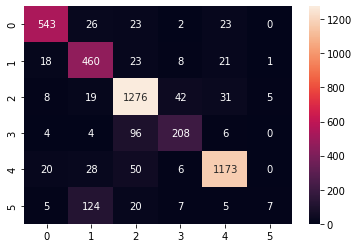

In [ ]:
print('Confusion Matrix')
print(sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,fmt="d"))

In [ ]:
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_name_mapping)

{'anger': 0, 'fear': 1, 'happy': 2, 'love': 3, 'sadness': 4, 'surprise': 5}


In [ ]:
#Example
def predict_emotion(stri):
    review = re.sub('[^a-zA-Z]', ' ', stri)
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    onehot_repr = [one_hot(review,voc_size)] 
    embed = pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
    predicti = model.predict(embed)
    return label_encoder.classes_[np.argmax(predicti)]

In [ ]:
predict_emotion('I am very happy and joyful today')

'happy'

In [ ]:
predict_emotion('He is an arrogant and rude person')

'anger'

In [ ]:
predict_emotion('The teacher is intimidating and scary')

'fear'

In [ ]:
predict_emotion('I am pretty bad')

'sadness'